In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import sklearn
from catboost import CatBoostClassifier
import random
import statsmodels.stats.weightstats

In [ ]:
!wget https://www.dropbox.com/s/anht24b6jf669mz/test.csv

In [ ]:
!wget https://www.dropbox.com/s/m47rgypr4oblj6d/train.csv

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## EDA

В ходе анализа рассмотрены следующие параметры:

* Баланс целевой функции
* Корреляции между признаками
* Распределения признаков

### Дисбаланс

In [4]:
def get_target_ratio(df):
    target_values = train_df.target.value_counts()
    return target_values[0]/target_values[1]

In [5]:
print('Соотношение классов равно: {:.3f}'.format(get_target_ratio(train_df)))
print('Целевая функция равномерно распределена на трейне и тесте.' 
      if get_target_ratio(test_df)==get_target_ratio(train_df) 
else 'Соотношение классов на тесте: {:.3f}'.format(get_target_ratio(test_df)))

Соотношение классов равно: 1.631
Целевая функция равномерно распределена на трейне и тесте.


### Корреляция

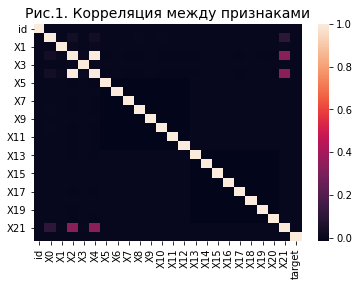

In [11]:
sns.heatmap(train_df.corr()).set_title('Рис.1. Корреляция между признаками',
                                       fontsize=14)
plt.show()

* Есть высокая зависимость между X2 и Х4 (чем выше рейтинг игрока, тем выше рейтинг противника)
* Небольшая корреляция X21 с X0, X2, X4 (время игры зависит от режима и рейтинга игроков: чем выше рейтинг, тем дольше игра)
* Небольшая корреляция X0 с X2 и Х4 (игроки с разным рейтингом предпочитают разные режимы)

Построим соответствующие графики для коррелирующих признаков

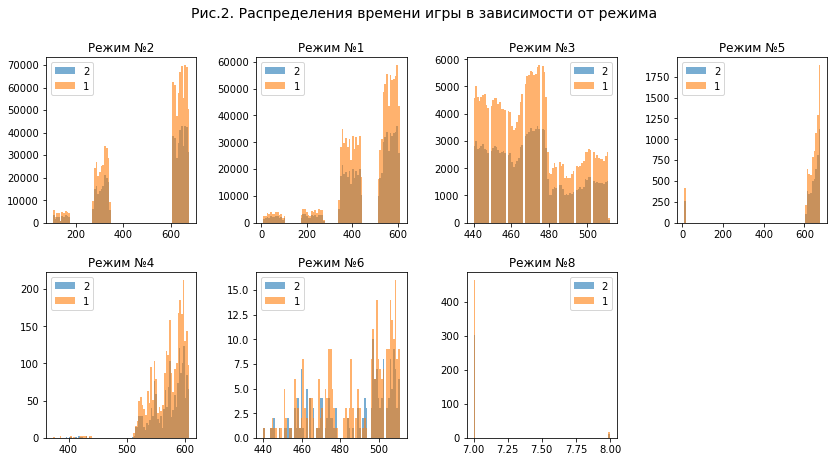

In [13]:
fig = plt.figure(figsize=(14,7))
targets = [2,1]
a = 2  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter
for i in train_df.X0.unique():
    plt.subplot(a, b, c)
    plt.hist(train_df.query('X0=='+str(i)+' & target==1').X21,
             bins=80,
             alpha=0.6)
    plt.hist(train_df.query('X0=='+str(i)+' & target==0').X21,
             bins=80,
             alpha=0.6)
    plt.title('Режим №'+str(i))
    plt.legend([str(i) for i in targets])
    c = c + 1
    
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)
fig.suptitle('Рис.2. Распределения времени игры в зависимости от режима',
             fontsize=14)
plt.show()

На рис.2 отчетливо заметна вариация распределений времени игры от режима:
* Для режима 1 характерны 4 участка: менее 150, от 150 до 300, от 300 до 500, более 500. Первые два участка практически равны по объему. Остальные два имеют объем в 10-20 раз больше.
* Для режима 2 характерны 3 участка: менее 200, от 200 до 400, более 600. 
* Для режима 3 характерны 3 участка: менее 460, от 460 до 480, более 480. 
* Для режима 4 характерны 2 участка: менее 500, более 500. Причем на втором участке можно выделить 4 промежутка, каждый из которых имеет свою моду. 
* Для режима 5 характерны 3 участка: менее 50, более 600. 
* Для режима 6 характерны 3 участка: менее 200, от 200 до 400, более 600. 
* Для режима 8 характерны лишь 2 значения: 7 и 8, большая часть сосредоточена на первом значении.

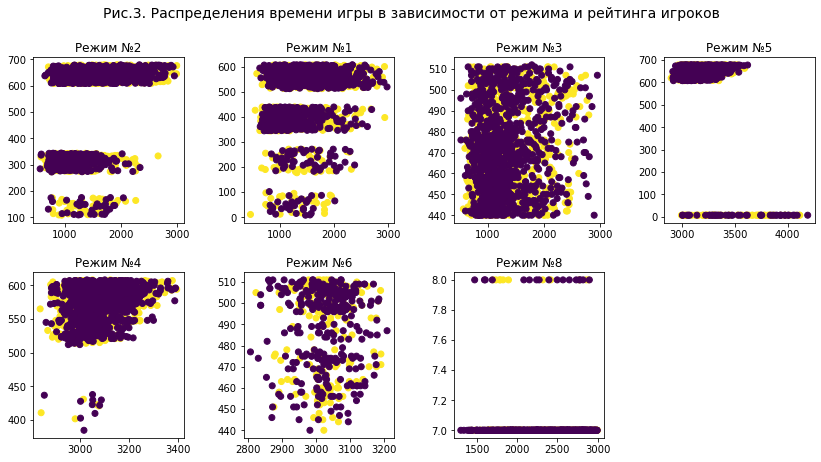

In [21]:
fig = plt.figure(figsize=(14,7))
targets = [2,1]
a = 2  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter
for i in train_df.X0.unique():
    plt.subplot(a, b, c)
    plt.scatter(pd.concat(
        [train_df.query('target==1 and X0=='+str(i)).X2[:1000],
         train_df.query('target==0 and X0=='+str(i)).X4[:1000]],
                          axis=0),
                pd.concat(
                    [train_df.query('target==1 and X0=='+str(i)).X21[:1000],
                     train_df.query('target==0 and X0=='+str(i)).X21[:1000]],
                          axis=0),
            c=pd.concat(
                [train_df.query('target==1 and X0=='+str(i)).target[:1000],
                 train_df.query('target==0 and X0=='+str(i)).target[:1000]],
                        axis=0))  
    plt.title('Режим №'+str(i))
    c = c + 1
    
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)
fig.suptitle('Рис.3. Распределения времени игры в зависимости от режима и рейтинга игроков',
             fontsize=14)
plt.show()

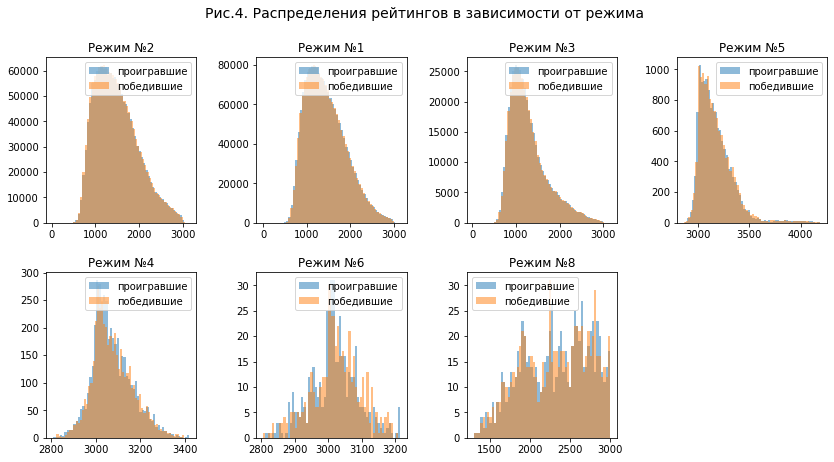

In [3]:
fig = plt.figure(figsize=(14,7))
targets = [2,1]
a = 2  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter
for i in train_df.X0.unique():
    plt.subplot(a, b, c)
    plt.hist(pd.concat([train_df.query(
        'X0=='+str(i)+' & target==1').X4,train_df.query(
        'X0=='+str(i)+' & target==0').X2],axis=0),
             bins=60,
             alpha=0.5)
    plt.hist(pd.concat([train_df.query(
        'X0=='+str(i)+' & target==0').X4,train_df.query(
        'X0=='+str(i)+' & target==1').X2],axis=0),
             bins=60,
             alpha=0.5)
    plt.title('Режим №'+str(i))
    plt.legend(['проигравшие','победившие'])
    c = c + 1
    
plt.subplots_adjust(wspace=0.4, hspace=0.3)
fig.suptitle('Рис.4. Распределения рейтингов в зависимости от режима',
             fontsize=14)
plt.show()

* На рис.3 и рис.4 можем увидеть, что распределения рейтингов игроков также зависят от режима игры. На графиках изображена лишь часть выборки для масштаба
* Также можно заметить выполнение условия, что в 1,2,3,5 режимах распределения победивших и проигравших практически совпадают

### Распределения признаков

In [7]:
def show_dist(df):
    fig = plt.figure(figsize=(20,10))
    sensors = [2,1]
    a = 4  # number of rows
    b = 6  # number of columns
    c = 1  # initialize plot counter
    for i in range(23):
        plt.subplot(a, b, c)
        plt.hist(df[df.columns[i]],
                 bins=60)
        plt.title(str(train_df.columns[i]))
        c = c + 1
    plt.subplots_adjust(wspace=0.4, 
                        hspace=0.3)
    fig.suptitle('Рис.5. Распределения признаков',
                 fontsize=14)
    plt.show()

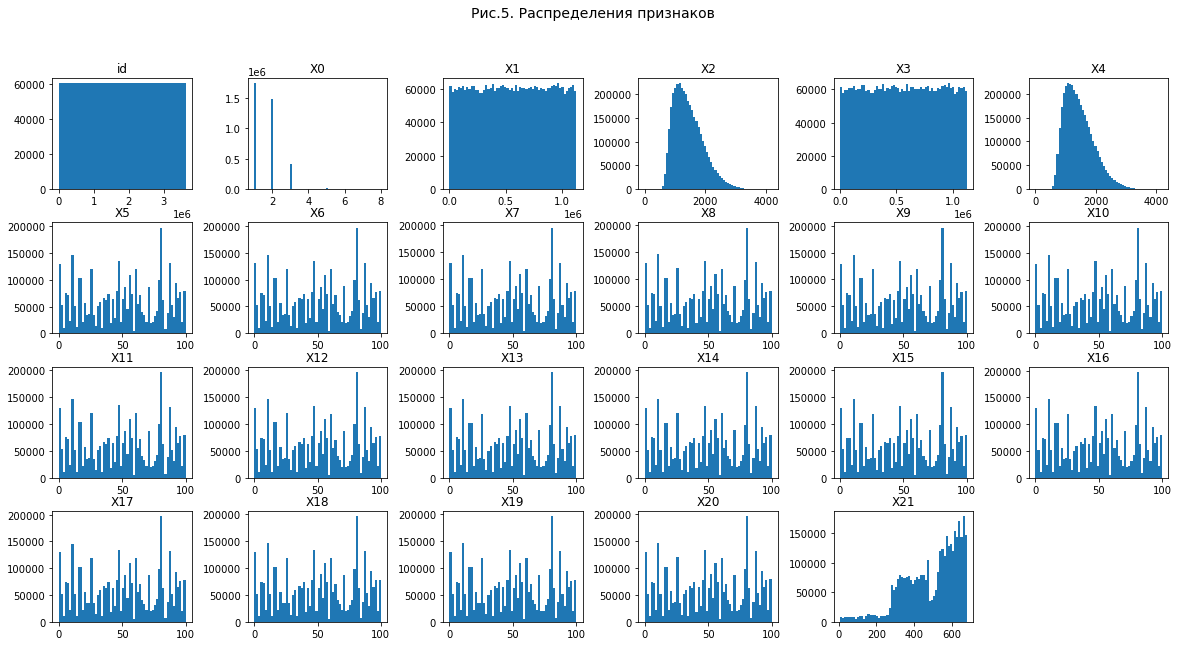

In [8]:
show_dist(train_df)

In [9]:
def show_dist_target(df):
    fig = plt.figure(figsize=(20,10))
    targets = [2,1]
    a = 4  # number of rows
    b = 6  # number of columns
    c = 1  # initialize plot counter
    for i in range(23):
        plt.subplot(a, b, c)
        plt.title('Значения {}'.format(df.columns[i]))
        for k in range(2):
            plt.hist(df[df['target']==k][df.columns[i]],
                     bins=70)
        if i==1:
            plt.xlabel('режим')
        c = c + 1
    plt.subplots_adjust(wspace=0.4, 
                        hspace=0.6)
    fig.suptitle('Рис.6. Распределение целевой функции от переменных',
                 fontsize=14)
    fig.legend(targets,title='Победа:')
    plt.show()

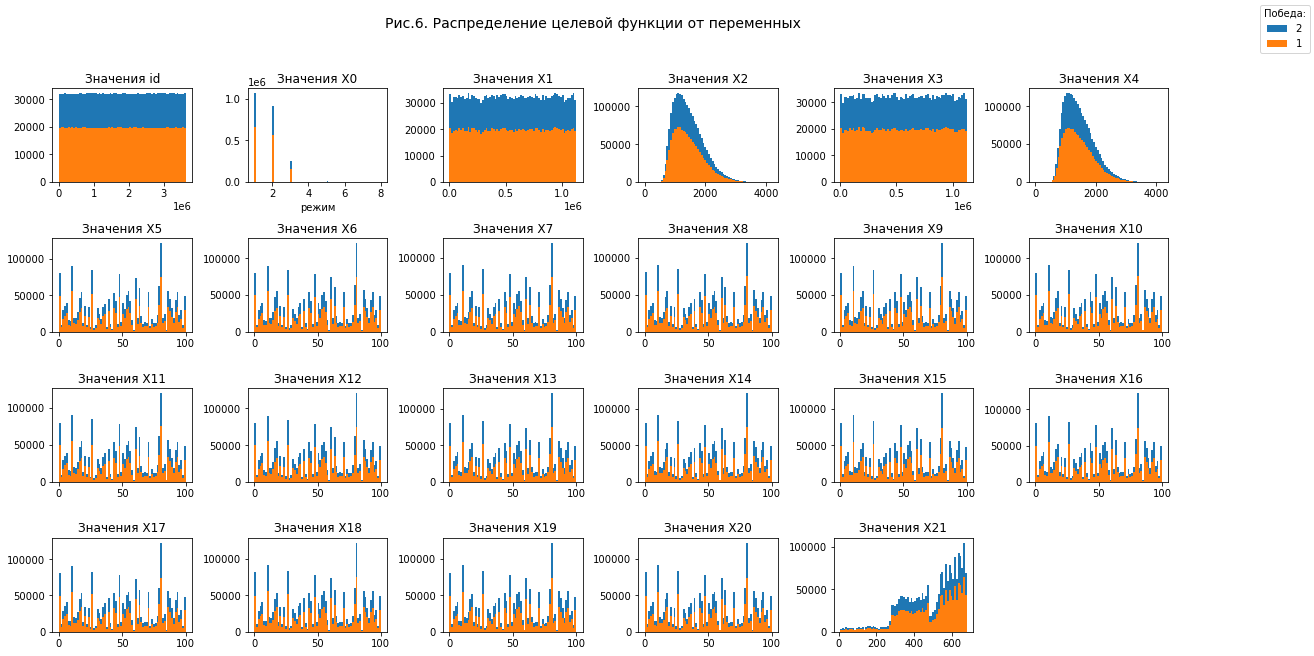

In [10]:
show_dist_target(train_df)

* Х0 (режим игры) имеет в основном значения от 1 до 3 
* X2 и X4 имеют одинаковое распределение
* Х1 и Х3 имеют похожие равномерные распределения
* Х5-Х20 имеют похожие распределения, что отражает отсутствие самого сильного юнита. Также существует 101 модификация юнита, все модификации различаются по частоте выбора
* X21 можно разделить на четыре сегмента: до 250, от 250 до 450, от 450 до 550, от 550. Причем если во втором и четвертом промежутке соотношение побед и проигрышей примерно пропорционально дисбалансу  классов, то в первом и третьем чаще выигрывает первый игрок. Распределение смещено влево.

In [110]:
num_unit = np.array([len(train_df['X'+str(i)].value_counts()) 
                     for i in range(5,21)])
np.unique(num_unit)

array([101])

Всего существует 101 модификация юнитов, каждая из которой присутствует в каждом столбце юнитов.

### Распределение  id-время
Посмотрим на диаграмму рассеивания классов в столбце индексов и времени на небольшом промежутке:

In [11]:
def show_id_target_freq(start_id,stop_id,start_time,stop_time):
    plt.scatter(train_df.query(
        'X21<'+str(stop_time)+' & X21>'+str(start_time)+' & target==0'
    )[start_id:stop_id].X0,train_df.query(
                    'X21<'+str(stop_time)+' & X21>'+str(start_time)+\
        ' & target==0')[start_id:stop_id].X21.index)
    plt.scatter(train_df.query(
        'X21<'+str(stop_time)+' & X21>'+str(start_time)+' & target==1'
    )[start_id:stop_id].X0,
                train_df.query(
                    'X21<'+str(stop_time)+' & X21>'+str(start_time)+\
                    ' & target==1')[start_id:stop_id].X21.index)
    plt.suptitle(
        'Рис.7. Распределение целевой переменной от порядкового номера игры',
        fontsize=14)
    plt.xlabel('режим')
    plt.ylabel('id')
    plt.show()

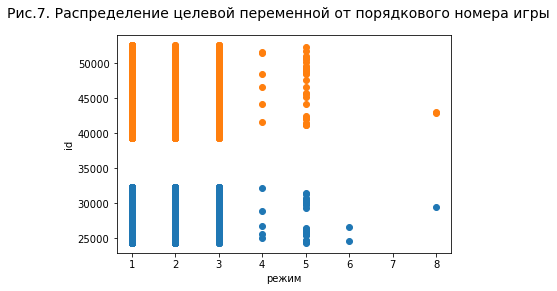

In [12]:
show_id_target_freq(15000,20000,0,800)

Объекты в датасете перемешаны следующим образом: упорядоченная в изначальном порядке выборка каждого класса на определенном промежутке значений индексов распределена на участке заданной ширины. Также можно заметить, что объекты равномерно распределены по переменной X0. 

### Вероятностные характеристики юнитов
* Частотные характеристики выбора юнитов (как часто выбирают юнитов)
* Вероятностные характеристики выигрыша юнитов (как часто выигрывает при наличии юнита)

In [6]:
def get_unit_freqrate(df):
    """
    Вычисляет значения частотных характеристик юнитов: 
    для каждого столбца юнита вычисляется число его появлений в играх
    затем нормируется на количество игр
    """
    units_col_freq = pd.DataFrame()
    for i in range(5,21):
        units_col_freq = pd.concat([units_col_freq,
                                    df['X'+str(i)].value_counts()],
                                   axis=1)
    units_col_freq = units_col_freq.apply(lambda x: x/len(df))
    units_freq = {}
    for i in units_col_freq.iterrows():
        units_freq[i[0]] = np.mean(np.array(i[1]))
    return units_freq

In [7]:
def get_unit_winrate(df):
    #Рассчитывает долю побед для каждого юнита
    wr = {}
    for u in range(101):
        winrate = np.zeros(16)
        for i in range(5,13):
            winrate[i-5] = len(df.query(
                'X'+str(i)+'=='+str(u)+' & target==1')
                              )/len(df.query('X'+str(i)+'=='+str(u)))
        for i in range(13,21):
            winrate[i-5] = len(df.query(
                'X'+str(i)+'=='+str(u)+' & target==0')
                              )/len(df.query('X'+str(i)+'=='+str(u)))
        wr[u] = np.mean(winrate) 
    return wr

In [10]:
#Вероятности выбора на трейне
train_unit_freqrate = get_unit_freqrate(train_df) 
#Вероятности выбора на тесте
test_unit_freqrate = get_unit_freqrate(test_df) 

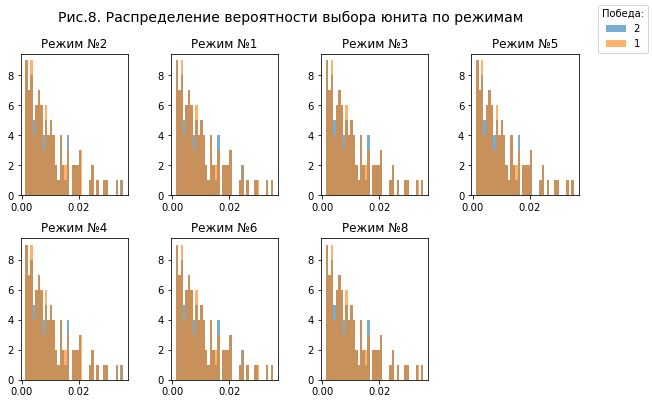

In [11]:
fig = plt.figure(figsize=(10,6))
targets = [2,1]
a = 2  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter
for mode in train_df.X0.unique():
    plt.subplot(a, b, c)
    plt.hist(list(get_unit_freqrate(
        train_df.query('X0=='+str(1)+' & target==0')).values()),
             bins=40,
             alpha=0.6)
    plt.hist(list(get_unit_freqrate(
        train_df.query('X0=='+str(1)+' & target==1')).values()),
             bins=40,
             alpha=0.6)
    c = c + 1
    plt.title('Режим №'+str(mode))
plt.subplots_adjust(wspace=0.4, hspace=0.3)
fig.suptitle('Рис.8. Распределение вероятности выбора юнита по режимам',
             fontsize=14)
fig.legend(targets,title='Победа:')
plt.show()

Юнитов выбирают одинаково часто в разных режимах

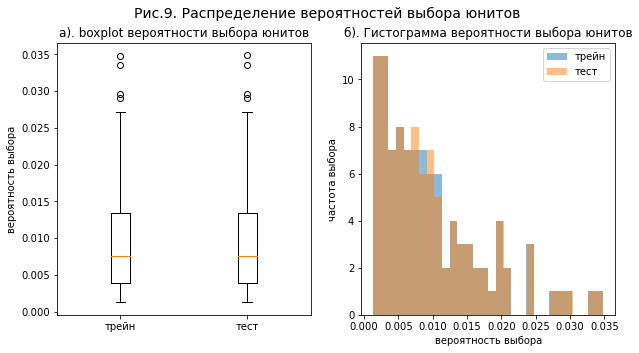

In [133]:
f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey='col',
                             sharex='col',
                             figsize=(10,5))
y= {'трейн':list(train_unit_freqrate.values()),
    'тест':list(test_unit_freqrate.values())}
ax1.boxplot(y.values())
ax1.set_xticklabels(y.keys())
ax2.hist(y['трейн'],
         bins=30,
         alpha=0.5)
ax2.hist(y['тест'],
         bins=30,
         alpha=0.5)
ax2.legend(['трейн', 'тест'])
ax1.set_ylabel('вероятность выбора')
ax2.set_ylabel('частота выбора')
ax2.set_xlabel('вероятность выбора')
ax1.title.set_text('а). boxplot вероятности выбора юнитов')
plt.title('б). Гистограмма вероятности выбора юнитов')
f.suptitle('Рис.9. Распределение вероятностей выбора юнитов',
           fontsize=14)
plt.show()

In [172]:
test_unit_freqrate_confint = statsmodels.stats.weightstats.DescrStatsW(
    list(test_unit_freqrate.values())).tconfint_mean()
print('95%-й доверительный интервал вероятности выбора того или иного юнита составляет: ',
      test_unit_freqrate_confint[0].round(3),'-', test_unit_freqrate_confint[1].round(3))

95%-й доверительный интервал вероятности выбора того или иного юнита составляет:  0.008 - 0.011


* Распределения выбора игроков на трейне и тесте практически совпадают
* В 95%-й доверительный интервал вероятности выбора попадает 1/101, значит юнитов выбирают в среднем с равной частотой
* На boxplot-графике заметны 4 юнита, которых выбирают заметно чаще, это юниты с номерами 10, 26, 48, 80

In [80]:
#Вероятности победы на трейне
train_unit_winrate = get_unit_winrate(train_df) 

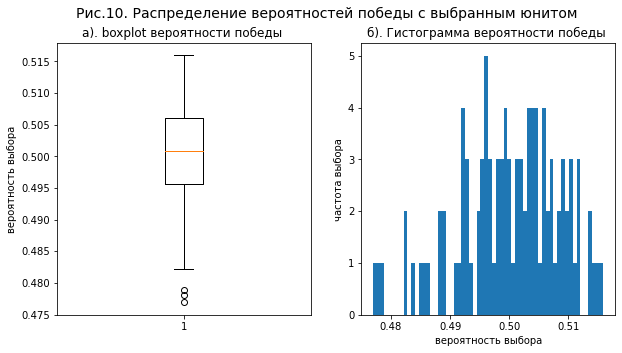

In [125]:
f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey='col',
                             sharex='col',
                             figsize=(10,5))
ax1.boxplot(list(train_unit_winrate.values()))
ax2.hist(list(train_unit_winrate.values()),
        bins=60)
ax1.set_ylabel('вероятность выбора')
ax2.set_ylabel('частота выбора')
ax2.set_xlabel('вероятность выбора')
ax1.title.set_text('а). boxplot вероятности победы ')
plt.title('б). Гистограмма вероятности победы ')
f.suptitle('Рис.10. Распределение вероятностей победы с выбранным юнитом',
           fontsize=14)
plt.show()

In [168]:
unit_winrate_confint = statsmodels.stats.weightstats.DescrStatsW(
    list(train_unit_winrate.values())).tconfint_mean()
print('95%-й доверительный интервал вероятности выбора того или иного юнита составляет: ',
      unit_winrate_confint[0].round(3),'-', unit_winrate_confint[1].round(3))

95%-й доверительный интервал вероятности выбора того или иного юнита составляет:  0.498 - 0.502


* Распределение вероятности выбора близко к нормальному
* На boxplot-графике можно заметить три юнита, вероятности выбора которых минимальны

In [164]:
#Вероятности победы при выбранном юните
train_winrate = {k : v * train_unit_winrate[k] 
                 for k, v in train_unit_freqrate.items() 
                 if k in train_unit_winrate} 

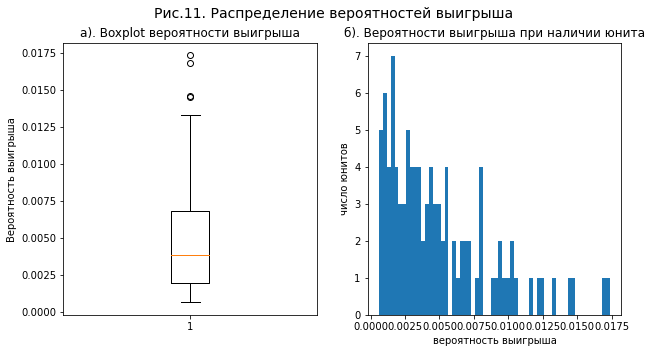

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey='col',
                             sharex='col',
                             figsize=(10,5))
ax1.boxplot(train_winrate.values())
ax2.hist(list(train_winrate.values()),
         bins=60)
ax1.set_ylabel('Вероятность выигрыша')
ax2.set_ylabel('число юнитов')
ax2.set_xlabel('вероятность выигрыша')
ax1.title.set_text('а). Boxplot вероятности выигрыша')
plt.title('б). Вероятности выигрыша при наличии юнита')
f.suptitle('Рис.11. Распределение вероятностей выигрыша',
           fontsize=14)
plt.show()

In [167]:
winrate_confint = statsmodels.stats.weightstats.DescrStatsW(
    list(train_winrate.values())).tconfint_mean()
print('95%-й доверительный интервал вероятности выбора того или иного юнита составляет: ',
      winrate_confint[0].round(3),'-', winrate_confint[1].round(3))

95%-й доверительный интервал вероятности выбора того или иного юнита составляет:  0.004 - 0.006


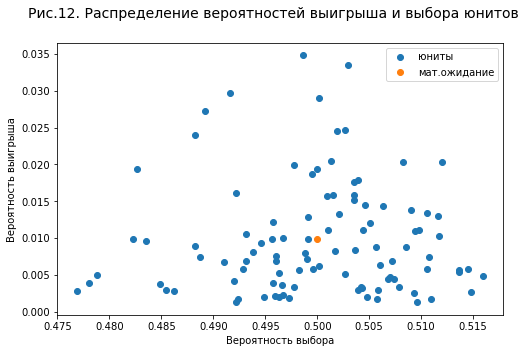

In [25]:
f, ax = plt.subplots(1, 1,
                     sharey='col',
                     sharex='col',
                     figsize=(8,5))
ax.scatter(train_unit_winrate.values(),
           train_unit_freqrate.values())
ax.scatter(np.mean(list(train_unit_winrate.values())),
           np.mean(list(train_unit_freqrate.values())))
ax.set_ylabel('Вероятность выигрыша')
ax.set_xlabel('Вероятность выбора')
ax.legend(['юниты','мат.ожидание'])

f.suptitle('Рис.12. Распределение вероятностей выигрыша и выбора юнитов',
           fontsize=14)
plt.show()

На рис. 12:
* На boxplot-графике заметно, что есть три юнита, с которыми выигрывают намного чаще

На рис. 13:
* Значительная часть объектов находится в нижнем правом углу: это юниты, которых часто "пикают" (выбирают), но вероятность выигрыша около среднего значения
* Значение средней вероятности выигрыша при наличии определенного юнита сильно смещено влево, что отражает правила о том, что нет самого сильного юнита
* Однако, есть несколько точек, которые существенно отличаются от общего распределения, расположенные выше 0.025. В левой части те юниты, которых редко выбирают, но когда их выбирают, они выигрывают чаще (скорее всего, сложные во взаимодействии юниты). Те, что ближе к верхнему правому углу, относятся к наиболее сильным юнитам, хоть их и немного.
Исходя из этого, можно попробовать заменить порядковые значения юнитов их вероятностными характеристиками, но, к сожалению, использовать в one-hot-encoding вероятностные характеристики юнитов не удалось из-за нехватки вычислительных ресурсов, но были проведены эксперимент с заменой стобцов значений юнитов Х5-Х20 на вероятностные характеристики и применение градиентного бустинга с ohe признаками, качество хуже, чем просто удаление данных столбцов (0.634 на HoldOut)

Рассмотрим распределения винрейтов игроков:

In [14]:
def replace_unit_winrate(df):
    for col in ['X'+str(i) for i in range(5,21)]:
        df[col] = df[col].replace(train_winrate)

In [15]:
#replace_unit_winrate(train_df)
#replace_unit_winrate(test_df)

In [22]:
#Рассчитывает винрейт игрока
def get_player_winrate(player_id):
    games_num = len(train_df.query('X1=='+str(player_id))) \
    + len(train_df.query('X3=='+str(player_id)))
    win_num = len(train_df.query('X1=='+str(player_id)+' & target==1')) \
    + len(train_df.query('X3=='+str(player_id)+' & target==0'))
    return win_num/games_num

In [141]:
#id всех игроков из обучающей выборки
train_players_set = list(set(train_df.X1).union(set(train_df.X3)))
#средние значения винрейтов игроков 
#из бутстрапированной выборки объема 300 из 50 игроков 
bs_players_winrate = []
for i in tqdm(range(300)):
    players_subset = [get_player_winrate(
            random.choice(train_players_set)) for m in range(50)]
    bs_players_winrate.append(np.mean(players_subset))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [19:39<00:00,  3.93s/it]


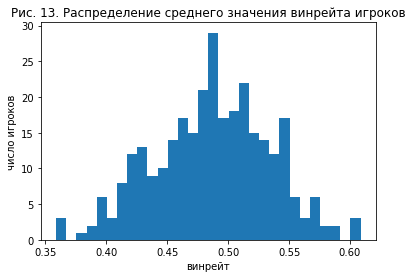

In [150]:
plt.hist(bs_players_winrate,
         bins=30)
plt.ylabel('число игроков')
plt.xlabel('винрейт')
plt.title('Рис. 13. Распределение среднего значения винрейта игроков')
plt.show()

In [170]:
winrate_confint = statsmodels.stats.weightstats.DescrStatsW(bs_players_winrate).tconfint_mean()
print('95%-й доверительный интервал винрейта игроков: ',
      winrate_confint[0].round(3),'-', winrate_confint[1].round(3))

95%-й доверительный интервал винрейта игроков:  0.481 - 0.492


* Распределение среднего значения винрейта игроков близко к нормальному
* Мат. ожидание среднего значения при данном объеме бутстрапированной выборки находится за пределами значения 0.5, но это связано с недостаточным объемом выборки. При увеличении объема выборки, заметен сдвиг интервала с правую сторону
* Можно попробовать заменить порядковые значения игроков их вероятностными характеристиками, но, к сожалению, использовать их не удалось из-за нехватки времени...

## Предобработка данных
Обработка данных для создания признаков включает в себя создание признаков и предобработку остальных.

При построении модели будут использоваться следующие признаки:
* Категориальные переменные: X0 (режим игры), Х1 (id 1го игрока), X3 (id 2го игрока), mode1-mode8 (Категория продолжительности игры)с помощью OHE для Х0, далее для каждого столбца создаются индикаторы для каждого участка распределения переменной X21 (по рис.2)
* Порядковые переменные: Х2, Х4 (рейтинги), Х21 (время), id 
* Вещественные признаки: unit1-unit202 с помощью OHE для признаков юнитов X5-X20 (индикатор имеющегося у каждого в отдельности игрока юнита из 101 варианта)
* (так как всего существует 101 вариация юнита, то закодируем в 202 столбца для 2 игроков)

Предобработка данных:
* Для порядковых и вещественных переменных: MinMaxScaler
* Остальные категориальные переменные преобразуются в текстовый формат

In [20]:
cat_cols = ['X0','X1','X3'] #категориальные признаки
mode_cols = ['mode'+str(i) for i in train_df.X0.unique()]

### Форматирование признаков

In [21]:
#Форматирует категориальные признаки в текстовый формат
def format_cat_cols(df):
    df[cat_cols] = df[cat_cols].astype(str)
    df[mode_cols] = df[mode_cols].astype(str)
    return df

In [5]:
#Форматирует целевую переменную в бинарный признак    
def format_target(df):
    df['target'] = df['target'].astype(np.int8)
    return df

### One-hot encoding преобразование 

#### Преобразование X0

In [49]:
#Каждому участку каждого режима присваивается номер
def make_mode_set(df):
    mode_set = pd.DataFrame(data=np.zeros((len(df),7)),
                            columns=['mode'+str(i) for i in df.X0.unique()],
                           dtype=np.int8)
    mode_set.iloc[df.query('X0==1 & X21<150').index,1] = 1
    mode_set.iloc[df.query('X0==1 & X21>150 & X21<300').index,1] = 2
    mode_set.iloc[df.query('X0==1 & X21>300 & X21<500').index,1] = 3
    mode_set.iloc[df.query('X0==1 & X21>500').index,1] = 4
    mode_set.iloc[df.query('X0==2 & X21<200').index,0] = 1
    mode_set.iloc[df.query('X0==2 & X21>200 & X21<400').index,0] = 2
    mode_set.iloc[df.query('X0==2 & X21>400').index,0] = 3
    mode_set.iloc[df.query('X0==3 & X21>400').index,2] = 1
    mode_set.iloc[df.query('X0==3 & X21<400').index,2] = 2
    mode_set.iloc[df.query('X0==4 & X21>500').index,4] = 1
    mode_set.iloc[df.query('X0==4 & X21<500').index,4] = 2
    mode_set.iloc[df.query('X0==5 & X21>600').index,3] = 1
    mode_set.iloc[df.query('X0==5 & X21<600').index,3] = 2
    mode_set.iloc[df.query('X0==6 & X21>480').index,5] = 1
    mode_set.iloc[df.query('X0==6 & X21<480').index,5] = 2
    mode_set.iloc[df.query('X0==8 & X21==7').index,6] = 1
    mode_set.iloc[df.query('X0==8 & X21==8').index,6] = 2
    return mode_set

In [15]:
train_df = pd.concat([train_df,
                      make_mode_set(train_df)],
                    axis=1)

#### Преобразование Х5-Х20

In [178]:
def fill_unit(array,indexes):
    #Меняет значение индикатора юнита в ohe-преобразовании
    for id in indexes:
        array[id] = 1

In [176]:
def make_unit_set(df):
    #Преобразование id юнитов с помощью one-hot encoding
    unit1_set = np.zeros((len(df), 101))
    for i in range(len(unit1_set)):
        unit = [int(df[k][i]) for k in ['X5','X6','X7','X8','X9','X10','X11','X12']]
        fill_unit(unit1_set[i],unit)
    
    unit2_set = np.zeros((len(df), 101))
    for i in range(len(unit2_set)):
        unit = [int(df[k][i]) for k in ['X13','X14','X15','X16','X17','X18','X19','X20']]
        fill_unit(unit2_set[i],unit)
        
    return pd.DataFrame(np.concatenate((unit1_set,unit2_set),axis=1),
                        dtype=np.int8,
                        columns=['unit'+ str(i) for i in range(1,203)])

### Нормализация 

In [16]:
#Нормализация в промежутке от 0 до 1 рейтингов и id всех игроков и времени игры 
def min_max(df):
    #Нормализация рейтингов
    rates = np.array(pd.concat([df.X2,df.X4],axis=0))
    rate_scaler = sklearn.preprocessing.MinMaxScaler()
    rate_scaler.fit(rates.reshape(-1,1))
    transformed_rates = rate_scaler.transform(
        rates.reshape(-1,1)).reshape(2,-1)
    df['X2'],df['X4'] = transformed_rates[0],transformed_rates[1]
    #Нормализация времени
    time_scaler = sklearn.preprocessing.MinMaxScaler()
    time_scaler.fit(np.array(df.X21).reshape(-1, 1))
    df.X21 = time_scaler.transform(
        np.array(df.X21).reshape(-1, 1))
    #Нормализация индексов
    id_scaler = sklearn.preprocessing.MinMaxScaler()
    id_scaler.fit(np.array(df.id).reshape(-1, 1))
    df.id = id_scaler.transform(np.array(df.id).reshape(-1, 1))
    return df

In [17]:
#Преобразование обучающей выборки
train_df = min_max(train_df)
train_df = format_target(format_cat_cols(train_df))
train_df = train_df.drop(columns=['X'+str(i) for i in range(5,21)])

In [24]:
train_df = pd.concat([train_df,
                     make_unit_set(train_df)],
                    axis=1)

### Разбиение на обучение и валидацию
Для получения итогового решения для обучения используется вся выборка, но для проверки алгоритма на качество выборка разбивается на обучающую и валидационную.

In [109]:
"""X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    train_df.drop(columns=['target']), train_df['target'],
    test_size=0.2,
    random_state=42)"""

## Построение модели

* В качестве модели используется классификатор, построенный на градиентном бустинге из библиотеки Catboost
* Подбор гиперпараметров будет осуществляться с помощью RandomSearch с дальнейшим поиском по сетке в окрестности.
* Число итераций равно 1000, так как большее число создает чересчур усложненную модель, не дает роста в качестве, а также вычислительно трудоёмко.

### Построение стандартной модели 

In [113]:
#clf_cb= CatBoostClassifier(cat_features=cat_cols+mode_cols,
#                           iterations=1000)
#clf_cb.fit(train_df.drop(columns=['target']), 
#           train_df['target'],
#           verbose=False)

Модель показала неплохие результаты, попробуем добиться улучшения при помощи настройки гиперпараметров

### Подбор гиперпараметров


#### Подбор шага градиента, глубины деревьев и коэффициента L2-регуляризации
Подбор осуществляется с помощью Random Search

In [198]:
grid = {'learning_rate': [0.32, 0.33, 0.34, 0.35, 0.36],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5]}

In [ ]:
clf_rs = CatBoostClassifier(cat_features=cat_cols)
randomized_search_result = clf_rs.randomized_search(grid,
                                                    X, y,
                                                    cv = 3,
                                                    n_iter=9)

In [222]:
clf_rs.get_params()

{'cat_features': ['X0', 'X1', 'X3'],
 'depth': 8,
 'l2_leaf_reg': 1,
 'learning_rate': 0.35}

Модель с данными параметрами показала лучший результат на private

#### Увеличение числа деревьев

In [54]:
#clf_cb= CatBoostClassifier(cat_features=cat_cols+mode_cols,
#                           iterations=1500)
#clf_cb.fit(train_df.drop(columns=['target']), 
#           train_df['target'],
#           verbose=False)

Увеличение числа деревьев показало лучший результат на public, но оказалось хуже на private, чем предыдущий метод подбора.

### Предсказание результатов

In [62]:
#Предобработка тестовых данных
test_df = min_max(test_df)
test_df = format_cat_cols(test_df)

In [61]:
test_df = pd.concat([test_df.drop(columns=['X'+str(i) for i in range(5,21)]),
                     make_unit_set(test_df)],
                    axis=1)
for col in ['unit'+str(i) for i in range(1,203)]:
    test_df[col] = test_df[col].astype(bool)

In [58]:
test_df = pd.concat([test_df,make_mode_set(test_df)],
                    axis=1)

In [ ]:
y_pred_rs = clf_rs.predict_proba(test_df)

In [ ]:
#Предсказание целевой функции
pd_subm = pd.DataFrame([y_pred_rs[i][1] for i in range(len(y_pred_rs))],
                       columns=['target'])
pd_subm.to_csv('sample_submission.csv')

## Выводы
* Были проведен EDA, в ходе него были выявлены зависимости между рейтингами пар игроков, а также времени и режима. Также проведен анализ распределения таких признаков, как вероятность победы того или иного юнита и игрока.
* Были созданы новые признаки, отражающие наличие юнитов из 101 предложенных, индикаторы различных участков для каждого из режимов, а также предобработка остальных признаков
* Был проведен эксперимент с заменой id юнитов на вероятности победы, что не дало улучшения качества
* Построена модель градиентного бустинга, а также подбор гиперпараметров: глубина дерева, размер шага и коэффициент регуляризации и число деревьев. Подбор первых трех параметров заметнее сказалось на качестве решения, возможно при увеличении числа деревьев результаты были бы еще лучше
* Итоговые результаты: logloss на public LB 0.61869, private LB 0.61989

In [112]:
results = pd.DataFrame([[0.61968,0.62083],
                        [0.61869,0.62032],
                        [0.61963, 0.61989]],
                       columns=['public','private'],
                       index=['standard catboost,lr=0.34',
                              'n_iter=1500,lr=0.34',
                              'l2_leaf_reg=1, depth=8,lr=0.35'])
def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight: bold' if cell else '' for cell in is_min]
results.style.apply(highlight_min,axis=0)

,public,private
"standard catboost,lr=0.34",0.619680,0.620830
"n_iter=1500,lr=0.34",0.618690,0.620320
"l2_leaf_reg=1, depth=8,lr=0.35",0.619630,0.619890
